In [1]:
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

     |████████████████████████████████| 138 kB 9.9 MB/s 


In [9]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchbearer
from torchbearer import Callback
from torchbearer import callbacks
from torchbearer import Trial
import torch 
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
from torchvision import transforms
from torch.utils.data import Dataset

class MyDataset(Dataset):
  def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

  def __getitem__(self, index):
      if index >= len(self):
          raise IndexError("{} index out of range".format(self.__class__.__name__))

      rng_state = torch.get_rng_state()
      torch.manual_seed(index + self.random_offset)

      while True:
        img = torch.zeros(self.dim, self.dim)
        dx = torch.randint(-10,10,(1,),dtype=torch.float)
        dy = torch.randint(-10,10,(1,),dtype=torch.float)
        c = torch.randint(-20,20,(1,), dtype=torch.float)

        params = torch.cat((dy/dx, c))
        xy = torch.randint(0,img.shape[1], (20, 2), dtype=torch.float)
        xy[:,1] = xy[:,0] * params[0] + params[1]

        xy.round_()
        xy = xy[ xy[:,1] > 0 ]
        xy = xy[ xy[:,1] < self.dim ]
        xy = xy[ xy[:,0] < self.dim ]

        for i in range(xy.shape[0]):
          x, y = xy[i][0], self.dim - xy[i][1]
          img[int(y), int(x)]=1
        if img.sum() > 2:
          break

      torch.set_rng_state(rng_state)
      return img.unsqueeze(0), params

  def __len__(self):
      return self.size

train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [10]:
# convert each image to tensor format
transform = transforms.Compose([
    transforms.ToTensor()  # convert to tensor
])

# create data loaders
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)
valloader = DataLoader(val_data, batch_size=128, shuffle=True)

In [26]:
epochs = 100

In [22]:
@callbacks.on_end_epoch
def metric_callback(state):
  train_loss[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['loss']
  val_loss[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['val_loss']

In [12]:
def plotgraph():
  fig, ax = plt.subplots(ncols=1, figsize=(8,3))
  ax.plot(train_loss, color = 'yellow', label = 'Train Loss')
  ax.plot(val_loss, color = 'orange', label = 'Test Loss')
  ax.grid(True)

  ax.legend(loc=1, fancybox=True, framealpha=0.3)
  
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  

In [23]:
def train_and_evaluate_model(model):
  # define the loss function and the optimiser
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.Adam(model.parameters())

  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], callbacks=[metric_callback] ).to(device)
  trial.with_generators(trainloader, valloader, test_generator=testloader)
  trial.run(epochs)
  plotgraph()

https://datascience.stackexchange.com/questions/40906/determining-size-of-fc-layer-after-conv-layer-in-pytorch

Task 1

In [24]:
# Model Definition 1
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), stride = 1, padding=1)
        self.fc1 = nn.Linear(48 * 40**2, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

0/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

0/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

1/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

1/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

2/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

2/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

3/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

3/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

4/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

4/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

5/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

5/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

6/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

6/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

7/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

7/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

8/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

8/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

9/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

9/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

10/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

10/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

11/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

11/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

12/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

12/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

13/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

13/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

14/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

14/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

15/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

15/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

16/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

16/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

17/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

17/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

18/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

18/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

19/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

19/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

20/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

20/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

21/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

21/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

22/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

22/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

23/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

23/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

24/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

24/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

25/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

25/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

26/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

26/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

27/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

27/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

28/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

28/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

29/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

29/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

30/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

30/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

31/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

31/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

32/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

32/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

33/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

33/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

34/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

34/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

35/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

35/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

36/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

36/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

37/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

37/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

38/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

38/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

39/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

39/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

40/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

40/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

41/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

41/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

42/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

42/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

43/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

43/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

44/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

44/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

45/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

45/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

46/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

46/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

47/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

47/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

48/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

48/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

49/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

49/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

50/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

50/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

51/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

51/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

52/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

52/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

53/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

53/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

54/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

54/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

55/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

55/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

56/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

56/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

57/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

57/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

58/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

58/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

59/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

59/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

60/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

60/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

61/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

61/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

62/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

62/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

63/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

63/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

64/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

64/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

65/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

65/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

66/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

66/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

67/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

67/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

68/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

68/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

69/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

69/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

70/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

70/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

71/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

71/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

72/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

72/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

73/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

73/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

74/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

74/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

75/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

75/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

76/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

76/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

77/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

77/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

78/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

78/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

79/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

79/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

80/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

80/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

81/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

81/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

82/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

82/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

83/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

83/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

84/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

84/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

85/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

85/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

86/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

86/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

87/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

87/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

88/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

88/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

89/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

89/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

90/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

90/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

91/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

91/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

92/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

92/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

93/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

93/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

94/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

94/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

95/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

95/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

96/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

96/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

97/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

97/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

98/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

98/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

99/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

99/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

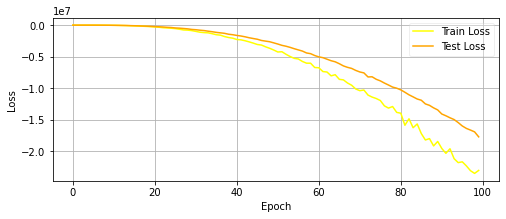

In [27]:
# build the model
model = SimpleCNN().to(device)
train_loss = np.zeros(epochs)
val_loss = np.zeros(epochs)
train_and_evaluate_model(model)

Task 2

In [28]:
# Model Definition 1
class SimpleCNNWithGlobalPooling(nn.Module):
    def __init__(self):
        super(SimpleCNNWithGlobalPooling, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), stride = 1, padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), stride = 1, padding=1)
        self.globalmaxpool1 = nn.AdaptiveMaxPool2d((1, 1))
        self.fc1 = nn.Linear(48 * 1**2, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.globalmaxpool1(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

0/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

0/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

1/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

1/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

2/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

2/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

3/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

3/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

4/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

4/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

5/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

5/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

6/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

6/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

7/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

7/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

8/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

8/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

9/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

9/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

10/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

10/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

11/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

11/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

12/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

12/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

13/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

13/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

14/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

14/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

15/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

15/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

16/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

16/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

17/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

17/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

18/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

18/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

19/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

19/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

20/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

20/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

21/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

21/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

22/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

22/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

23/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

23/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

24/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

24/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

25/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

25/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

26/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

26/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

27/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

27/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

28/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

28/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

29/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

29/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

30/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

30/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

31/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

31/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

32/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

32/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

33/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

33/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

34/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

34/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

35/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

35/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

36/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

36/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

37/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

37/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

38/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

38/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

39/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

39/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

40/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

40/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

41/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

41/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

42/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

42/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

43/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

43/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

44/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

44/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

45/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

45/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

46/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

46/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

47/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

47/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

48/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

48/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

49/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

49/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

50/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

50/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

51/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

51/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

52/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

52/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

53/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

53/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

54/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

54/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

55/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

55/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

56/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

56/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

57/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

57/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

58/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

58/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

59/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

59/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

60/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

60/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

61/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

61/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

62/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

62/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

63/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

63/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

64/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

64/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

65/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

65/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

66/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

66/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

67/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

67/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

68/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

68/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

69/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

69/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

70/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

70/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

71/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

71/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

72/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

72/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

73/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

73/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

74/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

74/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

75/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

75/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

76/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

76/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

77/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

77/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

78/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

78/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

79/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

79/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

80/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

80/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

81/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

81/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

82/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

82/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

83/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

83/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

84/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

84/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

85/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

85/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

86/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

86/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

87/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

87/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

88/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

88/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

89/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

89/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

90/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

90/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

91/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

91/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

92/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

92/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

93/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

93/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

94/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

94/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

95/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

95/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

96/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

96/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

97/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

97/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

98/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

98/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

99/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

99/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

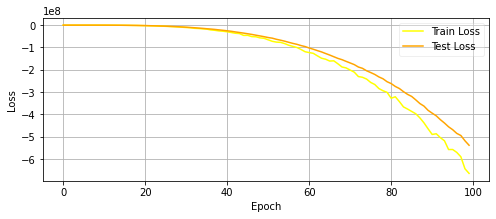

In [29]:
# build the model
model = SimpleCNNWithGlobalPooling().to(device)

train_loss = np.zeros(epochs)
val_loss = np.zeros(epochs)
train_and_evaluate_model(model)

Task 3

In [42]:
# Model Definition 3
class RegressCNN(nn.Module):
    def __init__(self):
        super(RegressCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, (3, 3), stride = 1, padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), stride = 1, padding=1)
        self.globalmaxpool1 = nn.AdaptiveMaxPool2d((1, 1))
        self.fc1 = nn.Linear(48 * 1**2, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        idxx = torch.repeat_interleave(torch.arange(-20,20, dtype=torch.float).unsqueeze(0) / 40.0, repeats=40, dim=0).to(x.device)
        idxy = idxx.clone().t()
        idx = torch.stack([idxx, idxy]).unsqueeze(0)
        idx = torch.repeat_interleave(idx, repeats=x.shape[0], dim=0)
        x= torch.cat([x, idx], dim=1)
        
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.globalmaxpool1(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

0/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

0/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

1/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

1/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

2/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

2/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

3/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

3/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

4/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

4/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

5/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

5/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

6/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

6/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

7/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

7/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

8/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

8/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

9/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

9/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

10/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

10/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

11/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

11/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

12/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

12/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

13/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

13/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

14/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

14/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

15/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

15/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

16/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

16/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

17/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

17/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

18/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

18/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

19/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

19/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

20/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

20/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

21/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

21/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

22/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

22/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

23/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

23/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

24/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

24/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

25/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

25/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

26/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

26/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

27/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

27/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

28/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

28/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

29/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

29/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

30/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

30/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

31/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

31/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

32/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

32/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

33/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

33/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

34/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

34/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

35/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

35/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

36/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

36/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

37/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

37/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

38/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

38/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

39/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

39/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

40/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

40/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

41/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

41/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

42/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

42/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

43/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

43/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

44/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

44/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

45/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

45/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

46/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

46/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

47/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

47/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

48/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

48/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

49/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

49/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

50/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

50/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

51/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

51/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

52/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

52/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

53/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

53/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

54/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

54/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

55/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

55/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

56/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

56/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

57/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

57/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

58/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

58/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

59/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

59/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

60/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

60/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

61/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

61/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

62/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

62/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

63/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

63/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

64/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

64/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

65/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

65/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

66/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

66/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

67/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

67/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

68/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

68/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

69/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

69/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

70/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

70/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

71/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

71/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

72/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

72/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

73/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

73/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

74/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

74/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

75/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

75/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

76/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

76/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

77/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

77/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

78/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

78/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

79/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

79/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

80/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

80/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

81/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

81/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

82/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

82/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

83/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

83/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

84/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

84/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

85/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

85/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

86/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

86/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

87/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

87/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

88/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

88/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

89/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

89/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

90/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

90/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

91/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

91/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

92/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

92/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

93/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

93/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

94/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

94/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

95/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

95/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

96/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

96/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

97/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

97/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

98/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

98/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

99/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

99/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

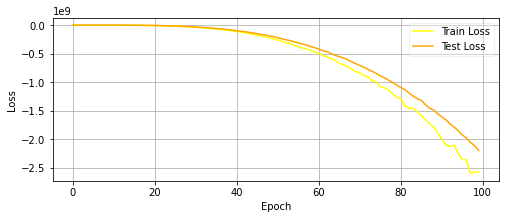

In [43]:
# build the model
model = RegressCNN().to(device)
train_loss = np.zeros(epochs)
val_loss = np.zeros(epochs)
train_and_evaluate_model(model)